# Ex1. Linear regression with time series

In this exercise, we will learn how to build `time step` and `target lag` feature, and train a linear regression model by using these features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# load book sale data
book_sale="../data/book_sales.csv"

book_sale_df = pd.read_csv(
    book_sale,
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

book_sale_df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


In [4]:
# add time step and lag feature
book_sale_df['Time'] = np.arange(len(book_sale_df.index))
book_sale_df['Lag_1'] = book_sale_df['Hardcover'].shift(1)
book_sale_df = book_sale_df.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

In [5]:
book_sale_df.head()

,Hardcover,Time,Lag_1
Date,,,
2000-04-01,139,0,NaN
2000-04-02,128,1,139.0
2000-04-03,172,2,128.0
2000-04-04,139,3,172.0
2000-04-05,191,4,139.0


In [6]:
ar_path="../data/ar.csv"

ar_df = pd.read_csv(ar_path)
ar_df.head()

,ar1,ar2
0,0.541286,-1.234475
1,-1.692950,3.532498
2,-1.730106,-3.915508
3,-0.783524,2.820841
4,-1.796207,-1.084120


In [8]:
store_sale_path="../data/store_sales/train.csv.zip"
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sale_df = pd.read_csv(
    store_sale_path,
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sale_df  = store_sale_df.set_index('date').to_period('D')
store_sale_df  = store_sale_df.set_index(['store_nbr', 'family'], append=True)
average_sale_df = store_sale_df.groupby('date').mean()['sales']

In [9]:
store_sale_df.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [10]:
average_sale_df.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

## 1.1 Interpret linear regression with the time step

One advantage linear regression has over more complicated algorithms is that the models it creates are *explainable* -- it's easy to interpret what contribution each feature makes to the predictions. In the model `target = weight * feature + bias`, the `weight` tells you by how much the `target` changes on average for each unit of change in the `feature`.

Run the next cell to see a linear regression on *Hardcover Sales*.

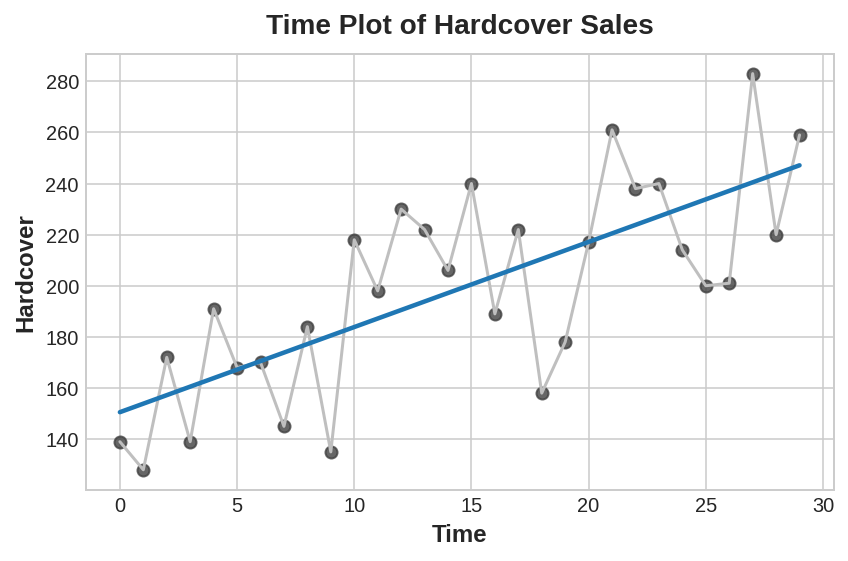

In [11]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sale_df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sale_df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');


### Q1 Get the hardcover sales after 6 days

With above figure, we can notice the linear regression line has an equation of (approximately) `Hardcover = 3.33 * Time + 150.5`. How much on average would you expect hardcover sales after 6 days?

```text
As we configured, each `time step` corresponds a day. So 6 days corresponds 6 time step.
A change of 6 days in Time corresponds to an average change of 6 * 3.33 = 19.98 in Hardcover sales.
````

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Consider the model `target = weight * lag_1 + error`, where `error` is random noise and `weight` is a number between -1 and 1. The `weight` in this case tells you how likely the next time step will have the same sign as the previous time step: a `weight` close to 1 means `target` will likely have the same sign as the previous step, while a `weight` close to -1 means `target` will likely have the opposite sign.



## 1.2 Interpret linear regression with a lag feature

Run the following cell to see two series generated according to the model just described.

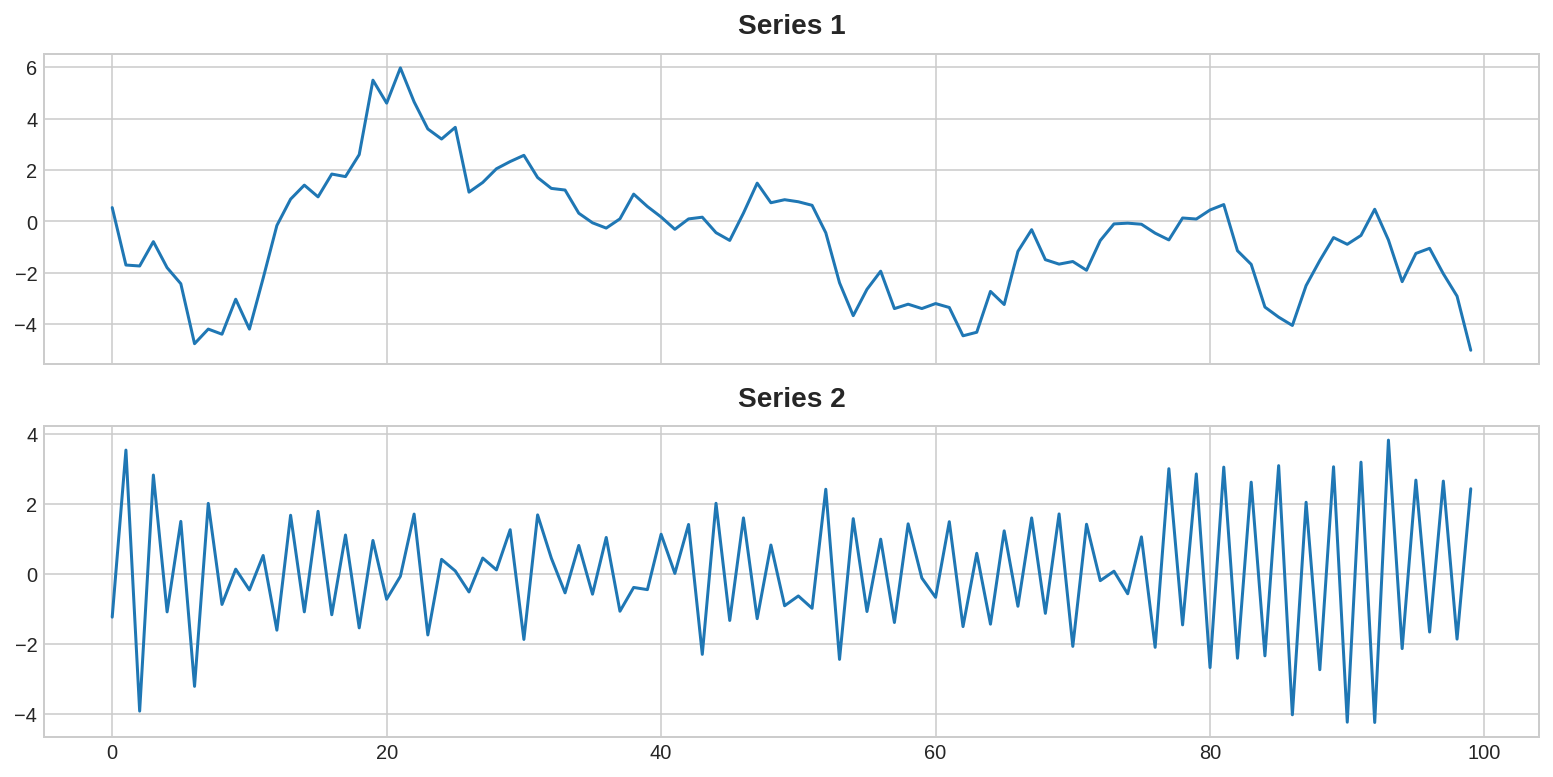

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
# series 1
ax1.plot(ar_df['ar1'])
ax1.set_title('Series 1')

# series 2
ax2.plot(ar_df['ar2'])
ax2.set_title('Series 2');

### Q2 Link the equation with series

One of these series has the equation target = 0.95 * lag_1 + error and the other has the equation target = -0.95 * lag_1 + error, differing only by the sign on the lag feature. Can you tell which equation goes with each series?


Series 1 was generated by `target = 0.95 * lag_1 + error` and Series 2 was generated by `target = -0.95 * lag_1 + error`.



## 1.3 Fit a time-step feature

Now we'll get started with the *Store Sales - Time Series Forecasting* competition data. The entire dataset comprises almost 1800 series recording store sales across a variety of product families from 2013 into 2017. For this lesson, we'll just work with a single series (`average_sales`) of the average sales each day.


Complete the code below to create a linear regression model with a time-step feature on the series of average product sales. The target is in a column called `'sales'`.

In [13]:
ts_df= average_sale_df.to_frame()
ts_df.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390808
2013-01-03,202.840195
2013-01-04,198.911148
2013-01-05,267.873230


In [14]:
# Create a time step column
time = np.arange(len(average_sale_df.index))

ts_df['time'] = time

#  Create training data
X = ts_df.loc[:, ['time']]   # features
y = ts_df.loc[:, 'sales']   # target


In [15]:
X.head()

,time
date,
2013-01-01,0
2013-01-02,1
2013-01-03,2
2013-01-04,3
2013-01-05,4


In [16]:
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [17]:
# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Run this cell if you'd like to see a plot of the result.

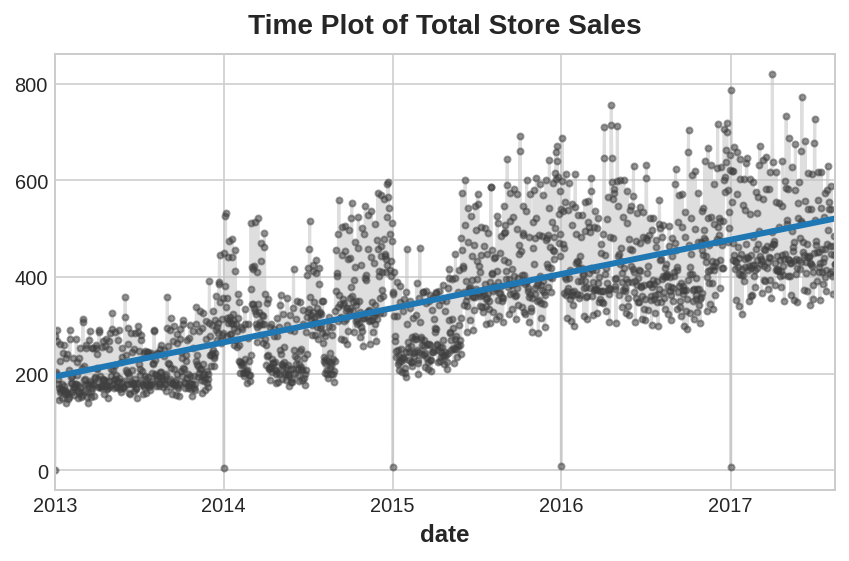

In [18]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

# 1.4 Fit a lag feature to Store Sales


Write the code to create a linear regression model with a lag feature on the series of average product sales.

In [19]:
lag_df = average_sale_df.to_frame()

# Create a lag feature from the target 'sales'
lag_1 = lag_df['sales'].shift(1)

lag_df['lag_1'] = lag_1  # add to dataframe

X = lag_df.loc[:, ['lag_1']].dropna()  # features
y = lag_df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# Create a LinearRegression instance.
lag_model = LinearRegression()
# fit it to X and y
lag_model.fit(X,y)

# Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(lag_model.predict(X),index=X.index)


Run the next cell if you'd like to see the result.

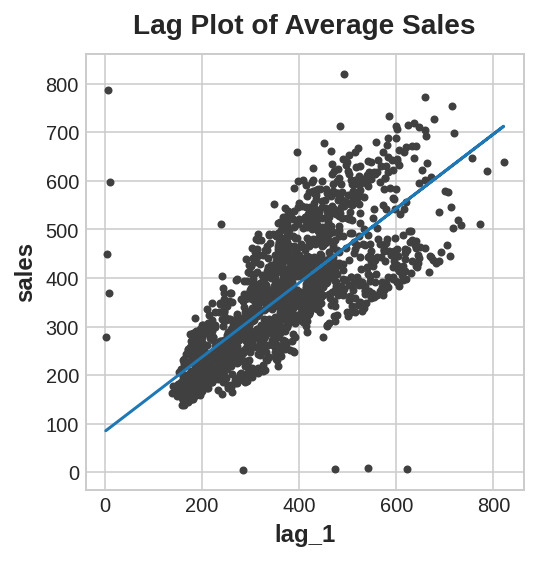

In [20]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');